1. DATA Understanding & Exploration

Initial Data Analysis

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


LOAD DATA as DataFrame
sales = pd.read_csv('training.csv')

In [68]:

pd.set_option('display.max_rows', None)

# See the data and shape, remove residual index column
# No NAs

sales = pd.read_csv("./training.csv")
sales= sales.iloc[:,1:]
print("Shape: ",sales.shape)
print("NA values", len(sales[sales.isna().any(axis=1)]))
print(sales.columns)
sales.head()

Shape:  (640840, 9)
NA values 0
Index(['store_ID', 'day_of_week', 'date', 'nb_customers_on_day', 'open',
       'promotion', 'state_holiday', 'school_holiday', 'sales'],
      dtype='object')


,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,366,4,2013-04-18,517,1,0,0,0,4422
1,394,6,2015-04-11,694,1,0,0,0,8297
2,807,4,2013-08-29,970,1,1,0,0,9729
3,802,2,2013-05-28,473,1,1,0,0,6513
4,726,4,2013-10-10,1068,1,1,0,0,10882


BASIC Data Exploration & EDA

No DOW distributions. Sizes:
 Series([], Name: sales, dtype: int64)


C:\Users\User\AppData\Local\Temp\ipykernel_1840\460867188.py:146: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(series_m, labels=labels_m, showfliers=False)


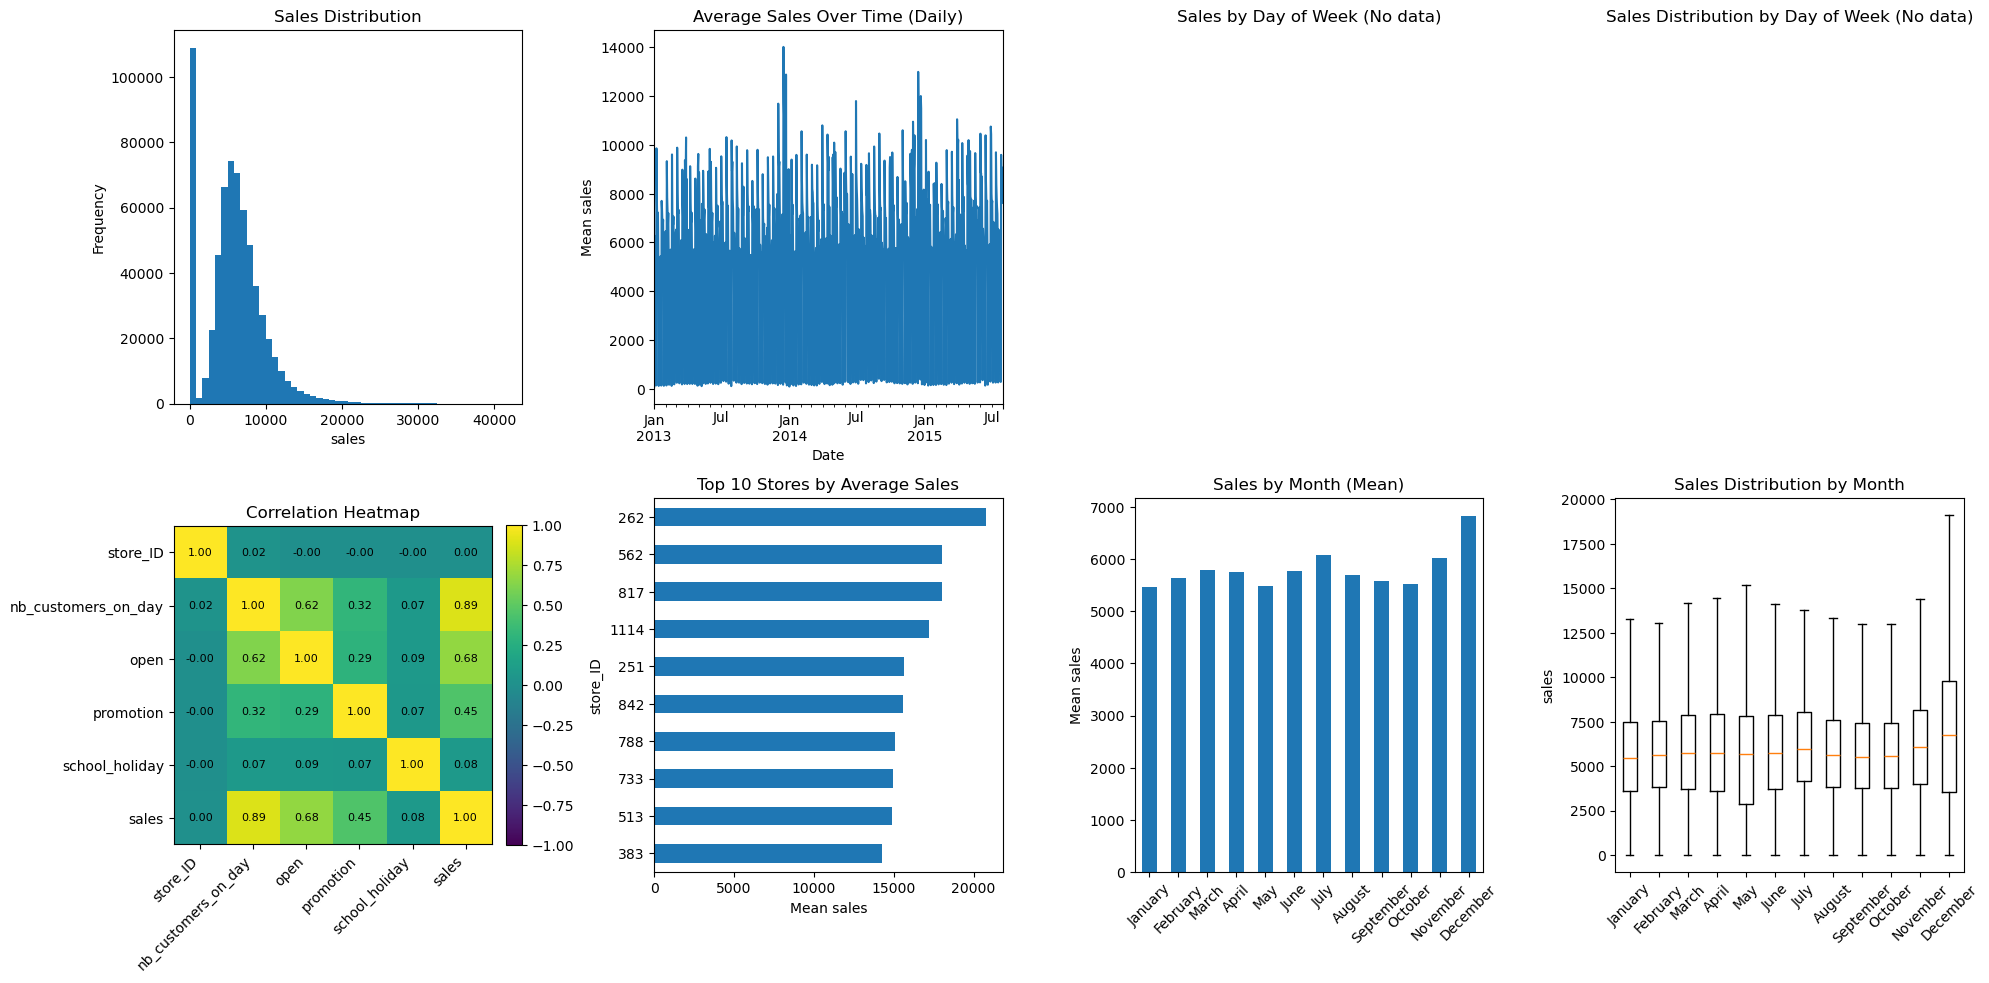

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def comprehensive_eda(
    sales,
    sales_col="sales",
    date_col="date",
    dow_col="day_of_week",     # if not present, will be created
    store_col="store_ID",
    top_n=10,
    figsize=(20, 10),
    debug=False,
):
    # --- Basic column checks
    needed = [sales_col, date_col, store_col]
    missing = [c for c in needed if c not in sales.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    data = sales.copy()

    # Ensure date & sales types
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")
    data[sales_col] = pd.to_numeric(data[sales_col], errors="coerce")
    data = data.dropna(subset=[date_col, sales_col])

    # Day-of-week (derive if missing) with logical order
    if dow_col not in data.columns:
        data[dow_col] = data[date_col].dt.day_name()
    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    data[dow_col] = pd.Categorical(data[dow_col], categories=dow_order, ordered=True)

    # Month-of-year (derive & order)
    month_order = ["January","February","March","April","May","June",
                   "July","August","September","October","November","December"]
    data["month_of_year"] = pd.Categorical(
        data[date_col].dt.month_name(), categories=month_order, ordered=True
    )

    # Aggregates
    daily_mean = (
        data.set_index(date_col)[sales_col]
            .resample("D").mean().sort_index()
    )
    dow_mean = data.groupby(dow_col, observed=True)[sales_col].mean().reindex(dow_order)
    moy_mean = data.groupby("month_of_year", observed=True)[sales_col].mean().reindex(month_order)

    top_stores = (
        data.groupby(store_col, observed=True)[sales_col]
            .mean().sort_values(ascending=False).head(top_n)
    )

    numeric_df = data.select_dtypes(include=[np.number])
    corr = numeric_df.corr(numeric_only=True) if not numeric_df.empty else pd.DataFrame()

    # --- Plotting: 2 x 4 grid (with DOW & Month distributions) ---
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.ravel()

    # 1) Sales distribution
    ax = axes[0]
    ax.hist(data[sales_col], bins=50)
    ax.set_title("Sales Distribution")
    ax.set_xlabel(sales_col); ax.set_ylabel("Frequency")

    # 2) Sales over time (daily mean)
    ax = axes[1]
    if not daily_mean.empty:
        daily_mean.plot(ax=ax)
        ax.set_title("Average Sales Over Time (Daily)")
        ax.set_xlabel("Date"); ax.set_ylabel(f"Mean {sales_col}")
    else:
        ax.set_title("Average Sales Over Time (No data)"); ax.axis("off")

    # 3) Mean by Day-of-Week
    ax = axes[2]
    if dow_mean.notna().any():
        dow_mean.plot(kind="bar", ax=ax)
        ax.set_title("Sales by Day of Week (Mean)")
        ax.set_xlabel(""); ax.set_ylabel(f"Mean {sales_col}")
        ax.tick_params(axis="x", rotation=45, labelrotation=45)
    else:
        ax.set_title("Sales by Day of Week (No data)"); ax.axis("off")

    # 4) Distribution by Day-of-Week (boxplots)
    ax = axes[3]
    labels_dow, series_dow = [], []
    for d in dow_order:
        s = data.loc[data[dow_col] == d, sales_col].dropna()
        if len(s) > 0:
            labels_dow.append(d); series_dow.append(s.values)
    if series_dow:
        ax.boxplot(series_dow, labels=labels_dow, showfliers=False)
        ax.set_title("Sales Distribution by Day of Week")
        ax.set_ylabel(sales_col); ax.tick_params(axis="x", rotation=45)
    else:
        if debug:
            print("No DOW distributions. Sizes:\n",
                  data.groupby(dow_col, observed=True)[sales_col].size())
        ax.set_title("Sales Distribution by Day of Week (No data)")
        ax.axis("off")

    # 5) Correlation heatmap
    ax = axes[4]
    if not corr.empty:
        im = ax.imshow(corr.values, vmin=-1, vmax=1)
        ax.set_title("Correlation Heatmap")
        ax.set_xticks(range(corr.shape[1])); ax.set_yticks(range(corr.shape[0]))
        ax.set_xticklabels(corr.columns, rotation=45, ha="right")
        ax.set_yticklabels(corr.index)
        for i in range(corr.shape[0]):
            for j in range(corr.shape[1]):
                ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=8)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.set_title("Correlation Heatmap (No numeric columns)"); ax.axis("off")

    # 6) Top stores
    ax = axes[5]
    if not top_stores.empty:
        top_stores.iloc[::-1].plot(kind="barh", ax=ax)
        ax.set_title(f"Top {min(top_n, len(top_stores))} Stores by Average Sales")
        ax.set_xlabel(f"Mean {sales_col}"); ax.set_ylabel(store_col)
    else:
        ax.set_title("Top Stores by Average Sales (No data)"); ax.axis("off")

    # 7) Sales by Month (Mean)
    ax = axes[6]
    if moy_mean.notna().any():
        moy_mean.plot(kind="bar", ax=ax)
        ax.set_title("Sales by Month (Mean)")
        ax.set_xlabel(""); ax.set_ylabel(f"Mean {sales_col}")
        ax.tick_params(axis="x", rotation=45, labelrotation=45)
    else:
        ax.set_title("Sales by Month (No data)"); ax.axis("off")

    # 8) Distribution by Month (boxplots)
    ax = axes[7]
    labels_m, series_m = [], []
    for m in month_order:
        s = data.loc[data["month_of_year"] == m, sales_col].dropna()
        if len(s) > 0:
            labels_m.append(m); series_m.append(s.values)
    if series_m:
        ax.boxplot(series_m, labels=labels_m, showfliers=False)
        ax.set_title("Sales Distribution by Month")
        ax.set_ylabel(sales_col); ax.tick_params(axis="x", rotation=45)
    else:
        if debug:
            print("No Month distributions. Sizes:\n",
                  data.groupby("month_of_year", observed=True)[sales_col].size())
        ax.set_title("Sales Distribution by Month (No data)")
        ax.axis("off")

    plt.tight_layout()
    return fig, axes

fig, axes = comprehensive_eda(
    sales,
    sales_col="sales",
    date_col="date",
    dow_col="day_of_week",   # will be created if missing
    store_col="store_ID",
    top_n=10,
    figsize=(20, 10),
    debug=True               # optional
)
plt.show()



In [113]:
# 1) Full EDA dashboard (includes the Month-of-Year panel)
fig, axes = comprehensive_eda(
    sales,
    sales_col="sales",
    date_col="date",
    dow_col="day_of_week",   # will be created if missing
    store_col="store_ID",
    top_n=10,
    figsize=(20, 10),
    debug=True               # optional
)
plt.show()

TypeError: comprehensive_eda() got an unexpected keyword argument 'debug'

KEY ANALYSIS AREAS:
- TEMPORAL patterns: seasonability, trends, day-of-week effects - features:
    
    : DAY OF THE WEEK / months important seasonability
    : No. of customers on day
    
- PROMOTIONAL data: Holidays; Special events; Marketing campaigns - features:
    Categorical - 
    : PROMOTION (0,1); State Holiday (mostly, some a,b,c, 0); School Holiday (0,1) 

- NA - Store characteristics: location, size, type 
- NA - Weather, economic indicators

2. Data Processing & Feature Engineering


In [ ]:
# 1. Add “month of year” to your sales DataFrame